In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

nan= float('nan')
pi= np.pi
e= np.e

c= 3e8
h= 6.62*10**-34
k= 1.38*10**-23

%load_ext autoreload
%autoreload 2

import QubeSpec as IFU
import QubeSpec.Plotting as emplot
import QubeSpec.Fitting as emfit
import yaml



True


# QubeSpec setup file - defining it again

In [4]:
# Lets define additional info
PATH='/Users/jansen/My Drive/Astro/'

QubeSpec_setup = {}
######################
# Basic Properties
QubeSpec_setup['z'] = 6.851 # Redshift of the object 
QubeSpec_setup['ID'] = 'COS30_R2700' # Name of the object
QubeSpec_setup['instrument'] = 'NIRSPEC_IFU_fl' # Name of the instrument - KMOS, SINFONI, NIRSPEC_IFU (when original units Fnu from pipeline), NIRSPEC_IFU_fl (for GTO pipeline Flambda)
QubeSpec_setup['band'] = 'R2700' # Or PRISM, doesnt matter for JWST - For KMOS and SINFONI it should H or K or HK or YJ or Hsin, Ksin for SINFONI
QubeSpec_setup['save_path'] = PATH+'COS30_IFS/Saves/' # Where to save all the info. 
QubeSpec_setup['file'] = PATH+'COS30_IFS/Data/COS30-COS-6.80-S_jw1217_o007_ff_px0.05_drizzle_ODfde95.0_VSC_MRC_MSA_EMSA_m2ff_xyspikes96_CTX1068.pmap_v1.8.2_g395h-f290lp_cgs_s3d.fits'# Path to the Data Cube
QubeSpec_setup['norm'] = 1e-15 # Normalization to make the integrated spectrum around 0.5-8

#####################
# PSF Matching info
QubeSpec_setup['PSF_match'] = True
QubeSpec_setup['PSF_match_wv'] = 5.2

#####################
# Masking Channels
QubeSpec_setup['mask_threshold'] = 6 # multiple of the median error to mask
QubeSpec_setup['mask_channels'] = []  # any particular channels to mask - with JWST not necessarily 

#####################
# Background Subtraction
QubeSpec_setup['Source_mask'] = PATH+'COS30_IFS/Data/R2700_source.fits' # path to find the source mask to mask the source during background subtraction - Can be None but then you have to supply wavelength range around some emission line to construct a line map and let sextractor create the mask
QubeSpec_setup['line_map_wavelength'] = [3.92,3.94] # Wavelength range used to create a line map for source detection - only used if 'Source_mask' is None

#####################
# Extracting spectrum 
QubeSpec_setup['Object_center'] = [59,50] # X,Y - center of the object 
QubeSpec_setup['Aperture_extraction'] = 0.2 # radius of the aperture to extract the the 1D spectrum
# Error stuff - explained below
QubeSpec_setup['err_range']=[3.95,4.05, 5,5.1] # err ranges for renormalising the error extension
QubeSpec_setup['err_boundary'] = 4.1 # where to switch - location of the detector gap

#####################
# Fitting Spaxel by Spaxel
QubeSpec_setup['Spaxel_mask'] = PATH+'COS30_IFS/Data/R2700_source_mask.fits' # which spaxel to fit in spaxel-by-spaxel fitting - source mask and Spaxel mask can be the same
QubeSpec_setup['ncpu'] = 8 # number of cores to use for 
QubeSpec_setup['Spaxel_Binning'] = 'Nearest' # What binning option to use  - 'Nearest', 'Single'


with open(QubeSpec_setup['save_path']+'QubeSpec_setup.yml', 'w') as outfile:
    yaml.dump(QubeSpec_setup, outfile, default_flow_style=False, allow_unicode=True)


In [2]:
Cube = IFU.Cube()
Cube.load('/Users/jansen/Test.txt')

# Preparing for Spaxel-by-spaxel fitting

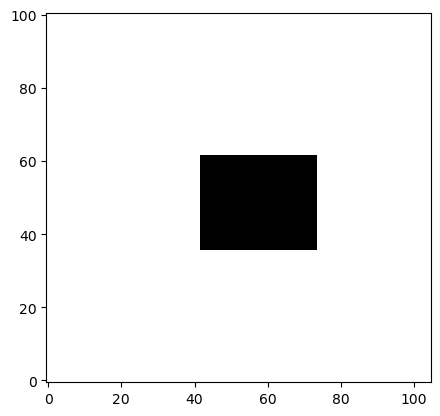

In [5]:
mask_spaxel = IFU.sp.QFitsview_mask(QubeSpec_setup['Spaxel_mask'])

plt.figure()
plt.imshow(mask_spaxel, cmap='gray', origin='lower')
plt.show()

## Unwrapping

In [6]:
Unwrapping = False
if Unwrapping==True:
    Cube.unwrap_cube(instrument='NIRSPEC05',mask_manual=mask_spaxel, \
                     err_range=QubeSpec_setup['err_range'],\
                     boundary=QubeSpec_setup['err_boundary'],\
                     add='',\
                     sp_binning= QubeSpec_setup['Spaxel_Binning']) 
plt.show()

In [ ]:
def gauss(x, k, mu,FWHM):
    sig = FWHM/3e5*mu/2.35482
    expo= -((x-mu)**2)/(2*sig*sig)

    y= k* e**expo

    return y
from astropy.modeling.powerlaws import PowerLaw1D

def Full_optical(x, z, cont,cont_grad,  Hal_peak, NII_peak, OIIIn_peak, Hbeta_peak, Hgamma_peak, Hdelta_peak, NeIII_peak, OII_peak, OII_rat,OIIIc_peak, HeI_peak,HeII_peak, Nar_fwhm):
    # Halpha side of things
    Hal_wv = 6564.52*(1+z)/1e4
    NII_r = 6585.27*(1+z)/1e4
    NII_b = 6549.86*(1+z)/1e4
    
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    Hal_nar = gauss(x, Hal_peak, Hal_wv, Nar_fwhm)
    NII_nar_r = gauss(x, NII_peak, NII_r, Nar_fwhm)
    NII_nar_b = gauss(x, NII_peak/3, NII_b, Nar_fwhm)
    
    Hgamma_wv = 4341.647191*(1+z)/1e4
    Hdelta_wv = 4102.859855*(1+z)/1e4
    
    Hgamma_nar = gauss(x, Hgamma_peak, Hgamma_wv, Nar_fwhm)
    Hdelta_nar = gauss(x, Hdelta_peak, Hdelta_wv, Nar_fwhm)
    
    
    # [OIII] side of things
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    OIII_nar = gauss(x, OIIIn_peak, OIIIr, Nar_fwhm) + gauss(x, OIIIn_peak/3, OIIIb, Nar_fwhm)
    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta, Nar_fwhm)
    
    NeIII = gauss(x, NeIII_peak, 3869.68*(1+z)/1e4, Nar_fwhm ) + gauss(x, 0.322*NeIII_peak, 3968.68*(1+z)/1e4, Nar_fwhm)
    
    OII = gauss(x, OII_peak, 3727.1*(1+z)/1e4, Nar_fwhm )  + gauss(x, OII_rat*OII_peak, 3729.875*(1+z)/1e4, Nar_fwhm) 
    
    OIIIc = gauss(x, OIIIc_peak, 4364.436*(1+z)/1e4, Nar_fwhm )
    HeI = gauss(x, HeI_peak, 3889.73*(1+z)/1e4, Nar_fwhm )
    HeII = gauss(x, HeII_peak, 4686.0*(1+z)/1e4, Nar_fwhm )

    contm = PowerLaw1D.evaluate(x, cont,Hal_wv, alpha=cont_grad)

    return contm+Hal_nar+NII_nar_r+NII_nar_b + OIII_nar + Hbeta_nar + Hgamma_nar + Hdelta_nar + NeIII+ OII + OIIIc+ HeI+HeII

labels= ['z', 'cont','cont_grad',  'Hal_peak', 'NII_peak', 'OIII_peak', 'Hbeta_peak','Hgamma_peak', 'Hdelta_peak','NeIII_peak','OII_peak','OII_rat','OIIIaur_peak', 'HeI_peak','HeII_peak', 'Nar_fwhm']

In [7]:
dvmax = 1000/3e5*(1+Cube.z)
dvstd = 200/3e5*(1+Cube.z)
priors={'z':[Cube.z,'normal_hat', Cube.z, dvstd, Cube.z-dvmax, Cube.z+dvmax]}

priors['cont']=[0.001,'loguniform', -4,1]
priors['cont_grad']=[0.1,'normal', 0,0.2]
priors['Hal_peak']=[0.1,'loguniform', -4,1]
priors['NII_peak']=[0.4,'loguniform', -4,1]
priors['Nar_fwhm']=[300,'uniform', 200,900]
priors['OIII_peak']=[0.1,'loguniform', -4,1]
priors['OI_peak']=[0.01,'loguniform', -4,1]
priors['HeI_peak']=[0.01,'loguniform', -4,1]
priors['Hbeta_peak']=[0.02,'loguniform', -4,1]
priors['Hgamma_peak'] = [0.02,'loguniform',-4,1]
priors['Hdelta_peak'] = [0.01,'loguniform',-4,1]
priors['NeIII_peak'] = [0.01,'loguniform',-4,1]
priors['OII_peak'] = [0.01,'loguniform',-4,1]
priors['OII_rat']=[1,'uniform', 0.2,4]
priors['OIIIc_peak']=[0.01,'loguniform', -4,1]

Spaxel = False
if Spaxel==True: 
    if __name__ == '__main__':
        IFU.Spaxel.Spaxel_fitting_general_MCMC_mp(Cube, Full_optical,labels, priors, emfit.logprior_general_scipy, add='', Ncores=QubeSpec_setup['ncpu'])


## Something didnt fit right? lets refit it. 

Things are bound to fail. In the next we will quickly fit only few spaxel and replace them in the saved file. 

In [ ]:
IFU.Spaxel.Spaxel_fitting_general_toptup(Cube, to_fit = [59,48], fitted_model = Full_optical, labels=labels, priors=priors, logprior= emfit.logprior_general_scipy)


## Generating the maps

In [ ]:
info = {'Hal': {'wv':6563,'fwhm':'Nar_fwhm','kin':1}}
info['NII'] = {'wv':6583, 'fwhm':'Nar_fwhm','kin':0}
info['OIII'] = {'wv':5008, 'fwhm':'Nar_fwhm','kin':1}
info['Hbeta'] = {'wv':4861, 'fwhm':'Nar_fwhm','kin':0}
info['Hgamma'] = {'wv':4341.647, 'fwhm':'Nar_fwhm','kin':0}
info['Hdelta'] = {'wv':4102.859, 'fwhm':'Nar_fwhm','kin':0}
info['NeIII'] = {'wv':3869.68, 'fwhm':'Nar_fwhm','kin':0}
info['OII'] = {'wv':3727.1, 'fwhm':'Nar_fwhm','kin':0}
info['OIIIc'] = {'wv':4363, 'fwhm':'Nar_fwhm','kin':0}
info['HeI'] = {'wv':3889, 'fwhm':'Nar_fwhm','kin':0}

fmaps = IFU.Maps.Map_creation_general(Cube, info,flux_max=1e-18, SNR_cut=4., fwhmrange=[200,600], velrange=[-200,200], \
                                  modelfce=Full_optical )
plt.show()

True


100%|██████████| 832/832 [22:24<00:00,  1.62s/it]


Failed fits 0
